# 0. Data Exploration

In this tutorial, we will become familiar with gamma-ray astronomical data from both _pointing_ and _all-sky_ instruments.

It is important to notice that the standardised gamma-ray data format can encapsulate and describe, with the same specifications, data from instruments relying on very different detection techniques.

In [1]:
# import libraries needed for the tutorial
# - basic libraries (numpy, astropy, regions, matplotlib)
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import PointSkyRegion, CircleSkyRegion, RectangleSkyRegion
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# - Gammapy libraries
from gammapy.data import EventList, Observation
from gammapy.maps import Map
from gammapy.stats import WStatCountsStatistic

## 0.1. *Fermi*-LAT data exploration
Let us examine first data from the *Fermi*-LAT telescope.   
This will mostly be a data-exploration tutorial. For a proper *Fermi*-LAT data analyses, the `Gammapy` developers recommend using the  [Fermi sciece tools](https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/) (ST) or their python wrapper [Fermipy](https://fermipy.readthedocs.io/en/latest/). `Gammapy`'s handling of *Fermi*-LAT is limited: the data we are going to use were reduced to a level compatible with `Gammapy` using the Fermi ST. Nonetheless, `Gammapy` provide an alternative for analyses not covered by the Fermi ST and for data combination.

After this disclaimer, let us start to examine the data.

### 0.1.1. Event list
The so-called _event list_, is one of the two fundamental parts of high-level gamma-ray data, as it contains fundamental quantities of the events classified as gamma-rays (energy, coordinates, arrival time, etc...) that are essential for any astronomical or physical analysis.

In [2]:
events_fermi = EventList.read("$GAMMAPY_DATA/fermi_3fhl/fermi_3fhl_events_selected.fits.gz")
print(events_fermi)

EventList
---------

  Instrument       : LAT
  Telescope        : GLAST
  Obs. ID          : 

  Number of events : 697317
  Event rate       : 0.003 1 / s

  Time start       : 54682.65603222222
  Time stop        : 57236.96833546296

  Min. energy      : 1.00e+04 MeV
  Max. energy      : 2.00e+06 MeV
  Median energy    : 1.59e+04 MeV




In [3]:
events_fermi.table

ENERGY,RA,DEC,L,B,THETA,PHI,ZENITH_ANGLE,EARTH_AZIMUTH_ANGLE,TIME,EVENT_ID,RUN_ID,RECON_VERSION,CALIB_VERSION,EVENT_CLASS,EVENT_TYPE,CONVERSION_TYPE,LIVETIME,DIFRSP0,DIFRSP1,DIFRSP2,DIFRSP3,DIFRSP4
MeV,deg,deg,deg,deg,deg,deg,deg,deg,s,,,,,,,,s,,,,,
float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int32,int32,int16,int16[3],bool[32],bool[32],int16,float64,float32,float32,float32,float32,float32
12856.5205,139.64438,-9.93702,241.10666,26.503777,53.82101,2.7517276,33.374527,130.10834,239557702.5977279,935735,239557414,0,0 .. 0,False .. True,False .. False,1,65.63486647605896,0.0,0.0,0.0,0.0,0.0
14773.319,177.04454,60.55275,136.40305,54.890198,30.75001,159.06378,65.68871,25.899567,239557849.66260877,1287791,239557414,0,0 .. 0,False .. True,False .. False,1,212.6997473537922,0.0,0.0,0.0,0.0,0.0
23273.527,110.21325,37.002018,181.24042,21.43271,26.81505,284.571,33.726536,336.16394,239557911.18056113,1419723,239557414,0,0 .. 0,False .. True,False .. False,1,26.771977096796036,0.0,0.0,0.0,0.0,0.0
41866.125,334.85287,17.577398,79.09332,-32.060402,69.85074,222.61414,72.51477,63.23222,239560204.05943003,2408188,239559565,0,0 .. 0,False .. True,False .. False,1,136.73515403270721,0.0,0.0,0.0,0.0,0.0
42463.074,316.86676,48.152477,89.35507,0.43455842,44.89138,270.80322,67.6372,20.348806,239560470.2141426,3120682,239559565,0,0 .. 0,False .. True,False .. True,0,88.30288392305374,0.0,0.0,0.0,0.0,0.0
10303.897,296.46106,63.347393,95.5988,18.278996,45.751953,300.94296,76.64709,2.4020715,239560523.59575307,3241034,239559565,0,0 .. 0,False .. True,False .. True,0,141.68449440598488,0.0,0.0,0.0,0.0,0.0
11243.208,309.96915,27.10396,69.624535,-8.816964,27.754541,244.8568,42.040264,21.26018,239560572.4084964,3345150,239559565,0,0 .. 0,False .. True,False .. False,1,28.560537308454514,0.0,0.0,0.0,0.0,0.0
23005.764,298.25528,17.233469,55.319416,-5.1971207,11.403744,201.78473,25.8502,349.23212,239560726.91094738,3642820,239559565,0,0 .. 0,False .. True,False .. False,1,17.178111046552658,0.0,0.0,0.0,0.0,0.0


We can start to check how the quantities stored in the list are distributed. Certainly energy and direction are the most important for astrophysical applications. Let us start by histogramming the energies.

The normal energy range of *Fermi*-LAT goes from 100 MeV to 2 TeV. This particular data set has been selected for a high-energy analysis that starts at 10 GeV. What shape does the distribution of energies have?

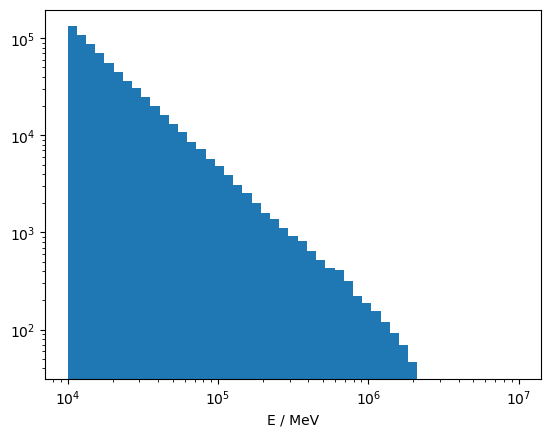

In [4]:
energy_bins = np.logspace(4, 7) # 100 GeV to 10 TeV (events energies are in MeV)
plt.hist(events_fermi.energy.value, bins=energy_bins)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("E / MeV")
plt.show()

Having a list of coordinates, we can try to plot a sky map, that is a two-dimensional histogram representing the number of photons observed from a given direction. Let us check first the spatial extent of our observation. Do we have events coming from all the directions in the sky, or just from a particular region.

First let us understand which reference frame we are using. We will consider galactic coordinates, in this reference frame we have two coordinates:
- a _longitude_, whose 0 angle represent the direction connecting the Earth to the centre of the Galaxy; 
- a _latitude_, whose 0 angle represent any point lying on the galactic plane.

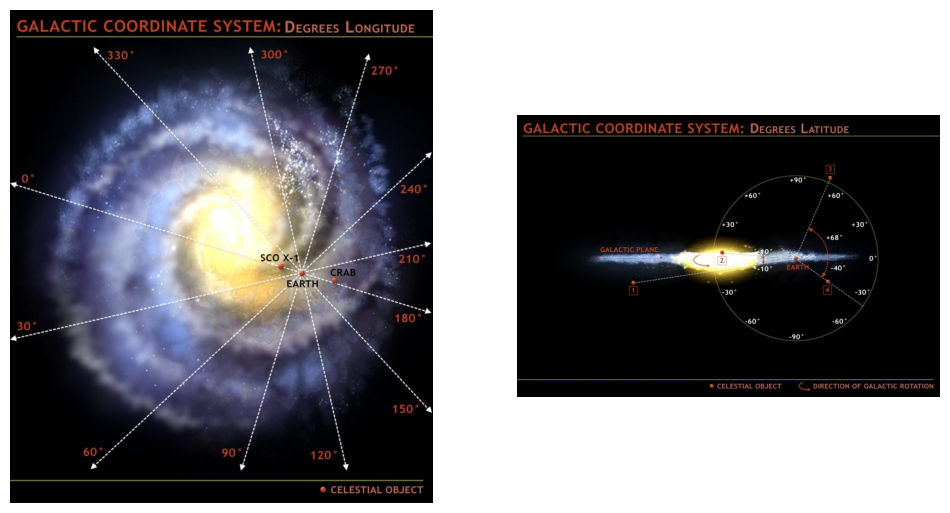

In [5]:
# read images
img_1 = mpimg.imread("figures/longitude_diagram_300dpi-768x896.jpg")
img_2 = mpimg.imread("figures/latitude_diagram_300dpi-1024x683.jpg")

# display images
fig, ax = plt.subplots(1,2, figsize=(12, 8))
ax[0].imshow(img_1)
ax[0].axis("off")
ax[1].imshow(img_2)
ax[1].axis("off")
plt.show()

Credit: [U. of Alabama](https://astronomy.ua.edu/undergraduate-program/course-resources-astronomy/lab-exercise-8-cosmic-distributions-and-the-galactic-ecology/1293-2/).

**Question**: which coordinates will the centre of the Galaxy have in this reference frame?

Back to our data, how could we check the coordinates of the events? Let us histogram them!

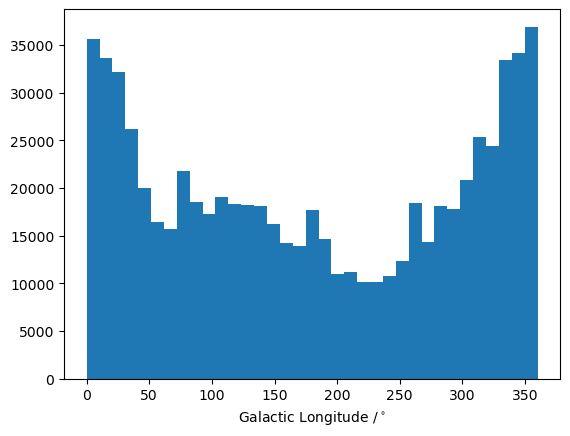

In [6]:
lon_bins = np.linspace(0, 360, 36)
plt.hist(events_fermi.galactic.l.value, bins=lon_bins)
plt.xlabel("Galactic Longitude " + r"$/\,^{\circ}$")
plt.show()

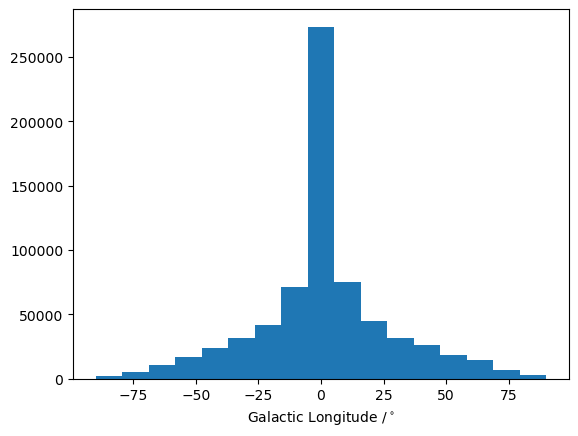

In [7]:
lat_bins = np.linspace(-90, 90, 18)
plt.hist(events_fermi.galactic.b.value, bins=lat_bins)
plt.xlabel("Galactic Longitude " + r"$/\,^{\circ}$")
plt.show()

Ok, it seems already that there is a particular range from which a lot of photons are coming.   
**Question**: can you guess which range of coordinates / region is?

Let us now do a two-dimensional histogram, zooming in on the region of the galactic centre.
There is tens of thousands of events, so let us choose only a subset within a rectangle of $10^{\circ} \times 4^{\circ}$ around the Galactic Centre.

In [8]:
coordinates_gc = SkyCoord(0, 0, unit="deg", frame="galactic")
rectangle = RectangleSkyRegion(center=coordinates_gc, width=10 * u.deg, height=8 * u.deg)
print(rectangle)

Region: RectangleSkyRegion
center: <SkyCoord (Galactic): (l, b) in deg
    (0., 0.)>
width: 10.0 deg
height: 8.0 deg
angle: 0.0 deg


In [9]:
# let us print the number of events before and after selecting
print(f"events before selection {len(events_fermi.table)}")
events_fermi_gc = events_fermi.select_region(regions = rectangle)
print(f"events after selection {len(events_fermi_gc.table)}")

events before selection 697317
events after selection 15616


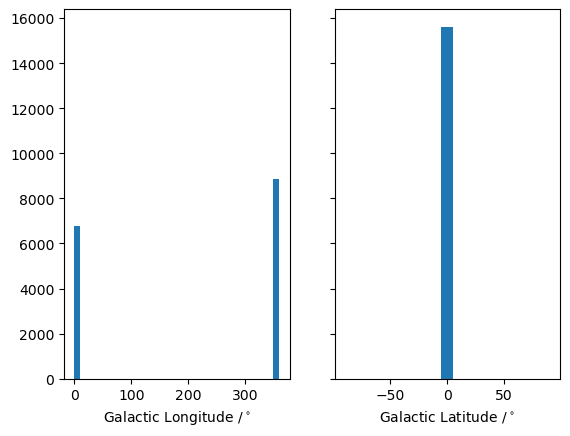

In [10]:
# just a quick check that the cut was applied
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].hist(events_fermi_gc.galactic.l.value, bins=lon_bins)
ax[1].hist(events_fermi_gc.galactic.b.value, bins=lat_bins)
ax[0].set_xlabel("Galactic Longitude " + r"$/\,^{\circ}$")
ax[1].set_xlabel("Galactic Latitude " + r"$/\,^{\circ}$")
plt.show()

I would be a complicated to create a skymap ourselves by filling a 2D histogram, mostly for two reasons:
1) we would have to find a way to wrap the coordinates around 0 (that is the range should go 5 -> 0 -> 365);
2) by filling a flat two-dimensional histogram we would distort the denisty of events (problem of mapping the surface of a sphere onto a flat surface).
For these reasons, we use `Gammapy`'s built-in [`Map`](https://docs.gammapy.org/dev/api/gammapy.maps.Map.html) class.

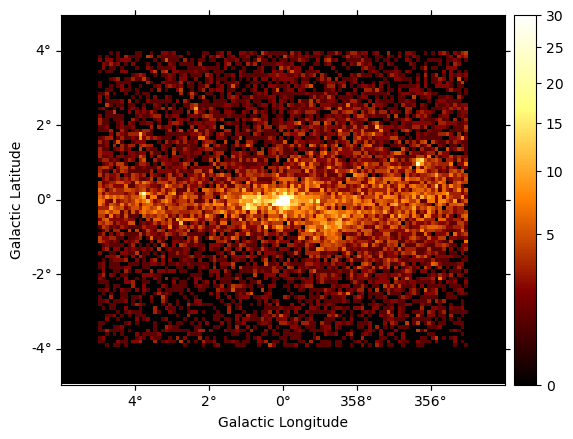

In [11]:
# let us create the skymap, fill it, and plot it
counts = Map.create(
    skydir=coordinates_gc,
    npix=(120, 100), # number of pixels in each direction
    proj="TAN",
    frame="galactic",
    binsz=0.1, # size of the square of each pixel
)
counts.fill_events(events_fermi_gc)
counts.plot(stretch="sqrt", vmax=30, add_cbar=True)
# NOTE: show the smoothing
plt.show()

### 0.1.2. Instrument response function

The instrument response function is the second component of our standardised, high-level, gamma-ray data. It parameterises the response of the systems, meaning, it tells us how estimated quantities relate to real one (e.g. reconstructed vs true energy). Additionally, through exposure or effective areas it gives us the possibility to convert observables from the "detector world" (e.g. counts) to the "physical world" (e.g. fluxes).

For _all-sky_ instruments the response function is given as a function of sky coordinates and energy, as we shall see for _Fermi_-LAT exposure. 

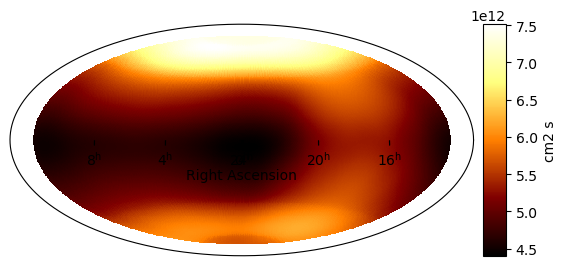

In [12]:
exposure_hpx = Map.read("$GAMMAPY_DATA/fermi_3fhl/fermi_3fhl_exposure_cube_hpx.fits.gz")
exposure_hpx.plot(add_cbar=True)
plt.show()

In general, the IRF is function both of sky coordinates and of energy. Let us look at the values of the exposure in the first energy bin.

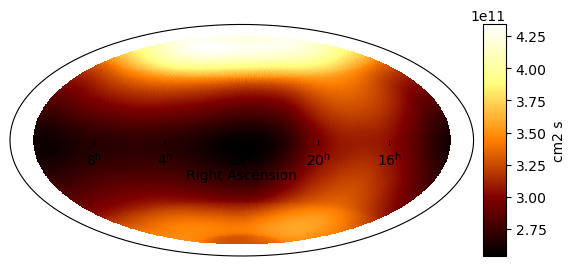

In [13]:
exposure_hpx.slice_by_idx({"energy_true": 0}).plot(add_cbar=True)
plt.show()

## 0.2. IACT data exploration (MAGIC and H.E.S.S.)
Let us now examine data from MAGIC and H.E.S.S., two IACTs, and therefore _pointing_ instruments.

### 0.2.1. Event lists
This time, events and IRF are incorporated in the same file. For IACT data we can use `Gammapy`'s `Observation` class. Let us start reading the events in one of the MAGIC files.

In [14]:
obs_magic = Observation.read("$GAMMAPY_DATA/magic/rad_max/data/20131004_05029747_DL3_CrabNebula-W0.40+035.fits")
events_magic = obs_magic.events

'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


In [15]:
events_magic.table

EVENT_ID,TIME,RA,DEC,ENERGY
,s,deg,deg,TeV
int64,float64,float32,float32,float32
2402,333778852.5099249,84.59457,22.03088,0.18194601
2408,333778852.5267153,84.21462,23.44914,0.08397394
2434,333778852.61315054,83.524704,22.725792,0.10596932
2445,333778852.6690142,83.76957,22.451006,0.19733498
2478,333778852.7627939,83.478516,23.484594,0.08522219
2481,333778852.7778549,83.71517,21.985115,1.0020943
2513,333778852.8644467,82.421196,22.567652,0.14374068
2544,333778852.9826064,83.64136,22.041315,0.10316629


We can see that there is much less information per each event with respect to *Fermi*-LAT's data. Let us try to histogram energies and coordinates again.
The energy range of MAGIC goes from 100 GeV to tens of TeV. As for the extent of the area of the sky observed, from the events' RA and DEC columns, it looks quite small, let us quickly check the extent.

In [16]:
delta_lon = np.max(events_magic.galactic.l.value) - np.min(events_magic.galactic.l.value)
delta_lat = np.max(events_magic.galactic.b.value) - np.min(events_magic.galactic.b.value)
print(f"area of the sky observed: {delta_lon:.2f} deg x {delta_lat:.2f} deg")

area of the sky observed: 4.94 deg x 4.75 deg


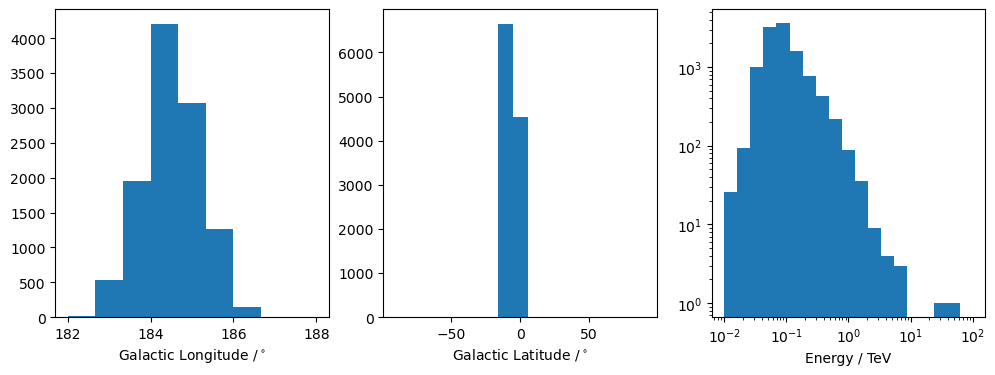

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

lon_bins = np.linspace(182, 188, 10)
lat_binning = np.linspace(-8, -2, 10)
energy_bins = np.logspace(-2, 2, 20) # 10 GeV to 10 TeV (events energies are in TeV)

ax[0].hist(events_magic.galactic.l.value, bins=lon_bins)
ax[1].hist(events_magic.galactic.b.value, bins=lat_bins)
ax[2].hist(events_magic.energy.value, bins=energy_bins)

ax[0].set_xlabel("Galactic Longitude " + r"$/\,^{\circ}$")
ax[1].set_xlabel("Galactic Latitude " + r"$/\,^{\circ}$")
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_xlabel("Energy / TeV")
plt.show()

`Gammapy` can produce all of these plots (including a skymap) automatically for us.

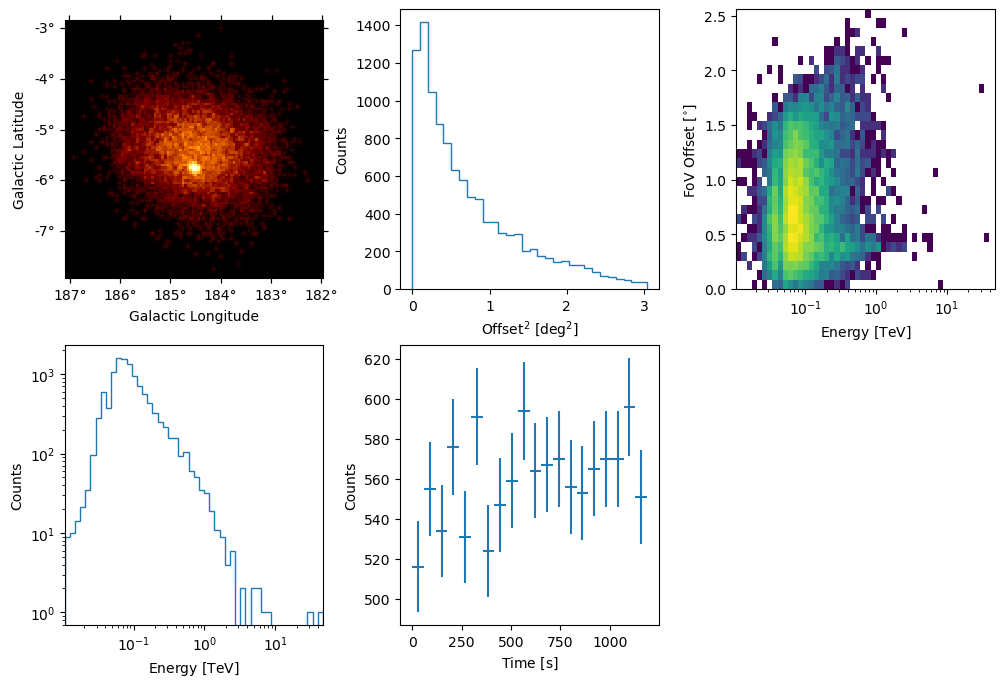

In [18]:
events_magic.peek()

### 0.2.2. IACT instrument response function
Let us check the effective area of the H.E.S.S. instrument (equivalent of the exposure for all-sky instruments).

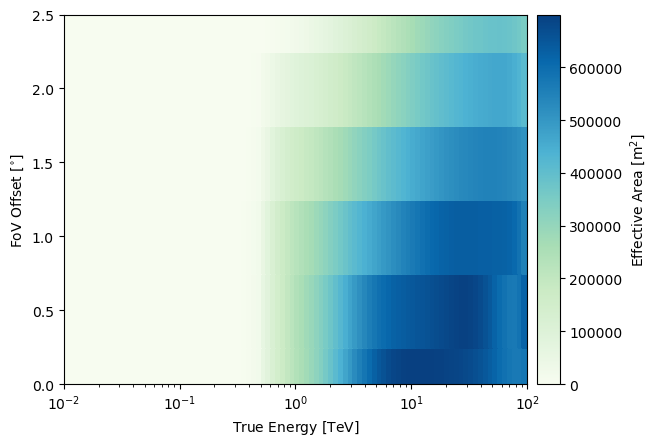

In [19]:
obs_hess = Observation.read("$GAMMAPY_DATA/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_023523.fits.gz")
obs_hess.aeff.plot()
plt.show()

This IRF component is a function of the energy and of the offset. As we are observing a small area of the sky, the spatial dependence of the IRF is more conveniently expressed as a function of the detector coordinates (offset from the camera centre rather than sky coordinates). In this particular case, we see that the IRF. If the source of our interest sits, for example at 0.4 or 1 degrees from the camera centre, we can evaluate the effective area there.

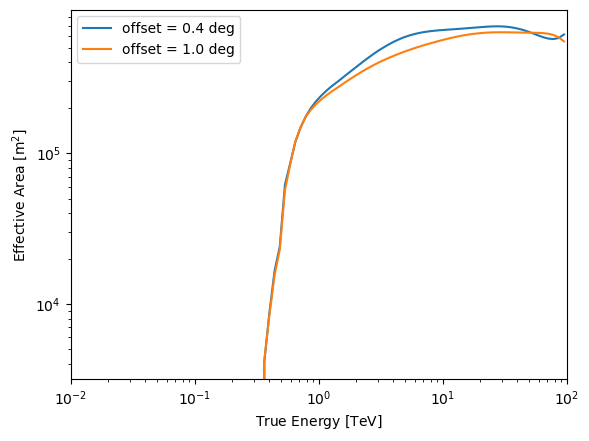

In [20]:
fig, ax = plt.subplots()
obs_hess.aeff.plot_energy_dependence(ax=ax, offset=[Angle("0.4 deg"), Angle("1 deg")])
ax.set_yscale("log")
plt.show()

## 0.3 The first estimation, significance of a signal
Let us consider one of the runs of MAGIC and let us estimate the significance of the gamma-ray signal from the Crab Nebula.
One of the techniques to estimate the strength of the signal in gamma-ray astronomy is known as _aperture photometry_. We will illustrate it step-by-step visually. 

Let us start by recreating a sky-map of the region around the Crab Nebula, the source observed in these runs from IACTs. 
Let us centre the map on the pointing position of the telescope.

/Users/cosimo/software/mambaforge/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:357: GammapyDeprecationWarning: obs_info property is deprecated since v1.2. Use meta instead.
  warnings.warn(


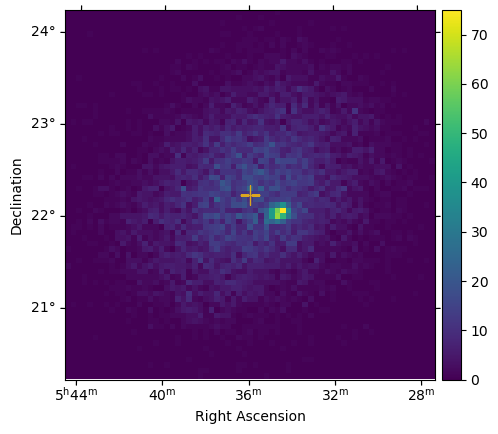

In [21]:
magic_pointing_radec = SkyCoord(
    ra=obs_magic.obs_info["RA_PNT"] * u.deg,
    dec=obs_magic.obs_info["DEC_PNT"] * u.deg,
    frame="icrs"
)
counts = Map.create(skydir=magic_pointing_radec, binsz=0.06, width=4)
# define wcs geom from the counts map
wcs = counts.geom.wcs

# fill the map and plot it, eventually cut in energy
counts.fill_events(events_magic)
ax = counts.plot(cmap="viridis", add_cbar=True)

# plot also the pointing
pointing = PointSkyRegion(magic_pointing_radec)
pointing.to_pixel(wcs).plot(ax=ax, color="goldenrod", marker="+", markersize=14)
plt.show()

It is quite clear where the source is, let us enclose the region we think contains the signal in a circle and count the events inside there. Let us start with a circle centred on the Crab Nebula nominal position and of radius 0.2 deg. We will call this region **ON** region.

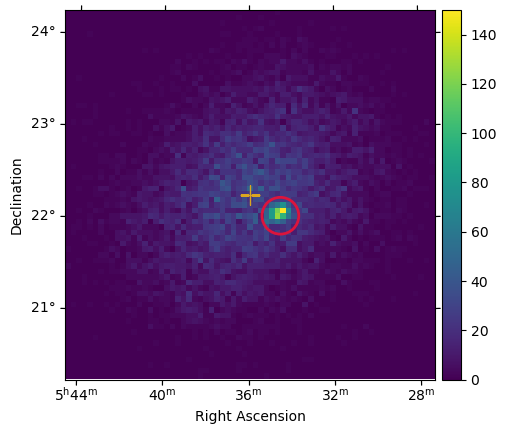

In [22]:
coordinates_crab = SkyCoord.from_name("Crab Nebula")
on_region = CircleSkyRegion(center=coordinates_crab, radius=0.2 * u.deg)

# overplot the ON region on the previous map
# fill the map and plot it, eventually cut in energy
counts.fill_events(events_magic)
ax = counts.plot(cmap="viridis", add_cbar=True)

# plot the pointing
pointing = PointSkyRegion(magic_pointing_radec)
pointing.to_pixel(wcs).plot(ax=ax, color="goldenrod", marker="+", markersize=14)
plt.plot()

# plot the ON region
on_region.to_pixel(wcs).plot(ax=ax, edgecolor="crimson", linewidth=2)

plt.show()

**Question**: can you figure why the telescope is not pointing exactly at the source? (It will become anyhow clear later).

How many events do we have within that circle?

In [23]:
on_events = events_magic.select_region(on_region)
n_on = len(on_events.table)
print(n_on)

871


In the **ON** region we also have background counts, i.e. events that are not real gamma rays. To subtract them, we estimate the background events from another region, that we refer to as **OFF**, that do not contain any real source of gamma ray data.
As we saw in the data exploration, for IACTs, the response of the system change with the distance from the centre, but it's symmetric in offset. So therefore, let us choose, to estimate the background, a region symmetric w.r.t. to the centre of the camera, to the **ON** region.

In [24]:
# estimate distance from the pointing to the centre of the ON region
pointing_offset = magic_pointing_radec.separation(coordinates_crab)
pointing_offset.to_value("deg")

0.40055507799593376

In [25]:
# let us create a region identical to the ON, but mirrored w.r.t. to the camera centre (i.e. rotated by 180 deg)
source_angle = magic_pointing_radec.position_angle(coordinates_crab)
off_region_angle = source_angle + 180 * u.deg
off_region_centre = magic_pointing_radec.directional_offset_by(position_angle=off_region_angle, separation=pointing_offset)

off_region = CircleSkyRegion(center=off_region_centre, radius=0.2 * u.deg)

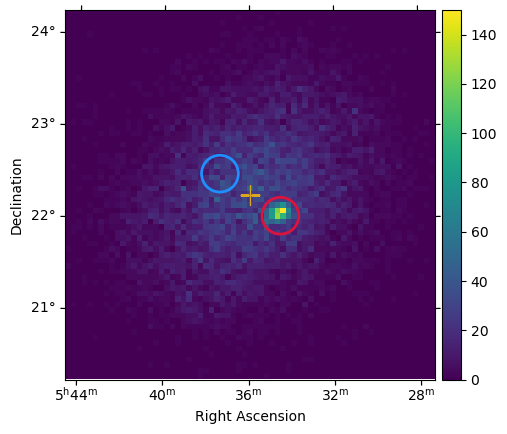

In [26]:
# replot everything
ax = counts.plot(cmap="viridis", add_cbar=True)

# plot the pointing
pointing = PointSkyRegion(magic_pointing_radec)
pointing.to_pixel(wcs).plot(ax=ax, color="goldenrod", marker="+", markersize=14)

# plot the ON and OFF regions
on_region.to_pixel(wcs).plot(ax=ax, edgecolor="crimson", linewidth=2)
off_region.to_pixel(wcs).plot(ax=ax, edgecolor="dodgerblue", linewidth=2)

plt.show()

In [27]:
off_events = events_magic.select_region(off_region)
n_off = len(off_events.table)
print(n_off)

389


What do we do with these two numbers?
We use Li & Ma formual to compute the significance. They are used also to estimate the excess counts significance, i.e. the probability that a given number of measured events actually contains some signal events, as well as the errors associated to this estimated number of signal counts.

In [28]:
statistics = WStatCountsStatistic(n_on=n_on, n_off=n_off, alpha=1)
statistics.sqrt_ts

13.753803407078085

## 0.4. Exercises for this tutorial

### 0.4.1.
Select an on region of $0.2^{\circ}$ around the nominal coordinates of the Crab. Create an histograms of the counts vs energy for the events contained in that region for both the MAGIC and the H.E.S.S. observations (create a figure with both histograms in the same plot).

### 0.4.2.
Compare, in the same plot, the effective areas of the MAGIC and H.E.S.S. observations at an offset of $0.4^{\circ}$ degree.